In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [29]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")

In [30]:
generator_llm = ChatOpenAI(model='gpt-4o-mini')
evaluator_llm = ChatOpenAI(model = 'gpt-4o')
optimizer_llm = ChatOpenAI(model = 'gpt-4o')

In [31]:
from pydantic import BaseModel,Field
from typing import TypedDict, Literal, Annotated

class TweetEvaluation(BaseModel):
    evaluation : Literal['approved','needs_improvement'] = Field(...,description='Final evaluation result')
    feedback : str = Field(...,description='feedback for the tweet')

In [32]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [54]:
import operator
class TweetState(TypedDict):

    topic : str
    tweet : str
    evaluation : Literal['approved','needs_improvement']
    feedback : str
    iteration : int
    max_iteration : int 

    tweet_history : Annotated[list[str],operator.add]
    feedback_history : Annotated[list[str],operator.add]

In [55]:
from langchain_core.messages import SystemMessage, HumanMessage
def generate_tweet(state:TweetState):

    messages = [
        SystemMessage(content='You are a funny and clever Twitter/X infuencer '),
        HumanMessage(content= f"""Write a short original, hilarious tweet on the topic {state['topic']}
        Rules:
        1. Do not use question answer format
        2. The tweets should be hilarious and practical
        3. The tweets should be original and authentic with dark humour, sarcasm
        4. Use simple day to day english
        5. Use punch lines, meme logics""")
    ]

    response = generator_llm.invoke(messages).content
    return {'tweet': response, 'tweet_history': [response]}

In [56]:
def evaluate_tweet(state: TweetState):

    #prompt 
    messages = [
        SystemMessage(content='You are a very strict tweet critic. You judge tweet on basis of humour, virality and format'),
        HumanMessage(content=f"""Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
    ]

    response = structured_evaluator_llm.invoke(messages)
    return{'evaluation': response.evaluation,'feedback': response.feedback,'feedback_history': [response.feedback]}
 



In [57]:
def optimize_tweet(state:TweetState):

    messages = [
                SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    response = optimizer_llm.invoke(messages).content
    state['iteration']+=1
    return{'tweet': response,'iteration': state['iteration']+1,'tweet_history': [response]}

In [58]:
def route_evaluation(state: TweetState):
    # stop if approved, or if we've hit the iteration cap
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    return 'needs_improvement'

In [59]:
from langgraph.graph import StateGraph,START, END

graph = StateGraph(TweetState)

graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')

graph.add_conditional_edges('evaluate',route_evaluation,{'approved':END,'needs_improvement':'optimize'})

graph.add_edge('optimize','evaluate')

workflow = graph.compile()

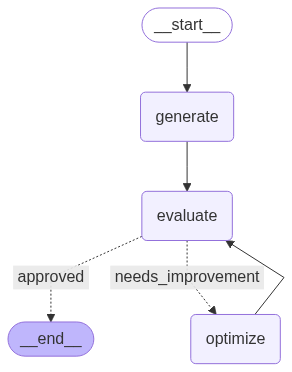

In [60]:
workflow

In [74]:
initial_state = {
    "topic": "Agentic AI",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)
result

{'topic': 'Agentic AI',
 'tweet': 'If Agentic AI ever takes over the world, I just hope it has a better sense of humor than my last boss. I mean, if it’s gonna enslave humanity, it might as well throw in some dad jokes, right? #EndOfDays #LaughOrCry',
 'evaluation': 'approved',
 'feedback': "The tweet is quite original, blending a contemporary topic about Agentic AI with a humorous comparison to the relatable experience of having a boss. Its humor comes from the unexpected twist of enslaving humanity being paired with the lighthearted suggestion of adding dad jokes to the mix. The structure is punchy and concise, fitting well within the 280-character limit. The hashtags boost its virality potential by making it relevant to trending themes of AI and existential humor. While it isn't groundbreaking in its humor, it manages to be engaging and relatable without falling into traditional joke formats.",
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['If Agentic AI ever takes over t

In [75]:
len(result['feedback_history'])

1